The structure of our tutorial will go as follows (it will follow pretty closely the tutorial from Ben sorcher which goes over his paper: https://github.com/ganguli-lab/grid-pattern-formation/blob/master/inspect_model.ipynb)

- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553 for rat foraging 
- Show real grid cell + place cell ratemaps  
- Plot simulated place cell ratemaps
- Plot simulated trajectories
- Get time-series of place cells
- Intro to RNNs
- Hardcoded RNNs that make grid cells (ila fiete paper 2009 https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1000291&type=printable): (matlab code here: https://www.dropbox.com/sh/ird9hnh8xbh76m8/AADIvXSqkUsWsVrUAoJFOU23a?e=1&dl=0, eqns from “IDEALIZED PATH INTEGRATOR MODELS” section in https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf )
- Train a RNN to predict place cells (ref ben sorscher paper)(Do with when only inputting place cell for time-step 0 and none thereafter)
- Plot RNN neuron ratemaps
- Train with/without Relu and see difference in ratemaps. Ideally would have hexagonal grids in relu case (like ben sorcher sees)
- Low dimensional population analysis to see torus (Fig 4 of https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf) + relate to low dimensional of real grid cells (figure from https://www.nature.com/articles/s41586-021-04268-7) as well as low dim analysis of idealised path integration model
- Eigen vals of RNN conectivity matrix and relate to idealised attractor connectivity matrices ( (Fig 5 of https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf)

# To install the package run the following
```
git clone --branch neuroai_tutorial https://github.com/SainsburyWellcomeCentre/NeuralPlayground
cd NeuralPlayground
pip install -e .[dev]
```

In [103]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import os
import pickle
import matplotlib as mpl
import scipy
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from neuralplayground.experiments import Sargolini2006Data
from neuralplayground.agents import TrajectoryGenerator, Burak2009, Sorscher2022exercise, SorscherIdealRNN
from neuralplayground.utils import PlaceCells, get_2d_sort
from neuralplayground.plotting import plot_trajectory_place_cells_activity, plot_ratemaps, compute_ratemaps
from neuralplayground.config import load_plot_config
load_plot_config()

# Show real grid cell + place cell ratemaps from sargolini

In [3]:
sargolini_data = Sargolini2006Data(verbose=True)

Dataset readme:
The sample includes conjunctive cells and head direction cells from layers III and V of medial entorhinal cortex and have  been published in 
Sargolini et al. (Science, 2006). 

The files are in matlab format. They include spike and position times for recorded cells from rats that were running in a 1 x 1 m
enclosure. The cells were recorded in the dorsocaudal 25% portion of the medial entorhinal cortex. Position is given for two LEDs 
to enable calculation of head direction.

The cell id is based on tetrode number and cell number (i.e: t2c7).

The file naming convention is as follow:

Rat number - session number _ cell id (i.e: 11084-03020501_t2c1).

Each session duration is normally 10 minutes, but some sessions are combination of 2 or more 10 minutes sessions, this is marked in 
the file name by using "+" between the session numbers (i.e: 11207-21060501+02_t6c1). Note that the 6 first digits in the session 
number is the date of the recording.

When loading the files 

rat_id   session                                      recorded_vars
rec_index                                                                    
0          11016  02020502                   [T5C1, T7C1, EEG, EGF, position]
1          11016  25010501                         [T6C2, EEG, EGF, position]
2          11016  28010501                         [T1C2, EEG, EGF, position]
3          11016  29010503       [T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]
4          11016  31010502  [T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit...

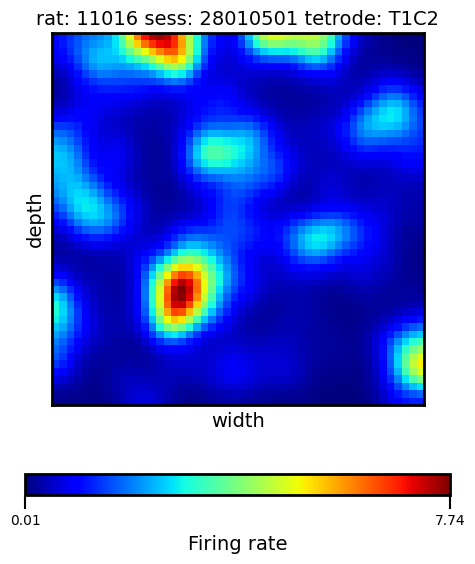

In [102]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
rate_map, x_bin, y_bin = sargolini_data.plot_recording_tetr(recording_index=2, ax=ax)

# Simulate trajectories and place cell activity
- Refactor the output so it doesn't have the extra dimensions
- Use more sequence steps so you keep track of the cells (batch size of 1)
- Color cell dots by position, then color their activity correspondingly

## Set variables for environment, animal trajectories and place cells

In [5]:
# Arena dimensions  Just 2D
room_width = 2.2
room_depth = 2.2

# We'll use a longer sequence just for plotting purposes
# Training will be done with short sequences
sequence_length = 300
batch_size = 4

# Place cells parameters
n_place_cells = 512
place_cell_rf = 0.12
surround_scale = 2.0
periodic = False
difference_of_gaussians = True

In [6]:
place_cells = PlaceCells(Np=n_place_cells, 
                         place_cell_rf=place_cell_rf,
                         surround_scale=surround_scale, 
                         room_width=room_width, 
                         room_depth=room_depth, 
                         periodic=periodic, 
                         DoG=difference_of_gaussians,
                         device=device)

The following trajectory generator is based on https://github.com/ganguli-lab/grid-pattern-formation/blob/master/trajectory_generator.py which implements https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553

In [7]:
generator = TrajectoryGenerator(sequence_length, batch_size, room_width, room_depth, device, place_cells=place_cells)
traj = generator.generate_trajectory(room_width, room_depth, batch_size)
x, y = traj["target_x"], traj["target_y"]

In [106]:
for key in traj.keys():
    print(key, traj[key].shape)

init_hd (256, 1)
init_x (256, 1)
init_y (256, 1)
ego_v (256, 20)
phi_x (256, 20)
phi_y (256, 20)
target_hd (256, 20)
target_x (256, 20)
target_y (256, 20)


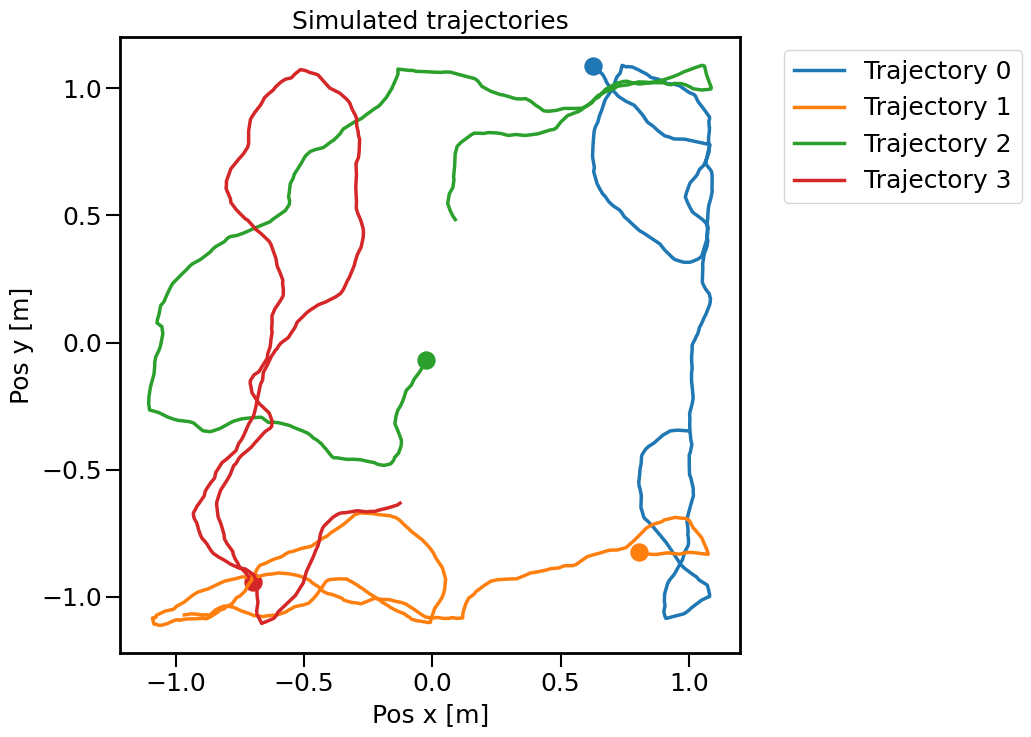

In [9]:
# Plotting options
plot_n_trajectories = batch_size
figure_size = (8, 8)
line_width = 2.5
marker_size = 150

# Plot trajectories
fig, ax = plt.subplots(1, 1, figsize=figure_size)
for i in range(plot_n_trajectories):
    init_x = traj["init_x"][i]
    init_y = traj["init_y"][i]
    ax.plot(x[i, :], y[i, :], label=f"Trajectory {i}", linewidth=line_width)
    ax.scatter(init_x, init_y, color=f"C{i}", marker="o", s=marker_size)
ax.set_xlabel("Pos x [m]")
ax.set_ylabel("Pos y [m]")
ax.set_title("Simulated trajectories")
# Putting the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [10]:
# Plot activity for one of the trajectories
trajectory_id = 2
trajectory = np.stack([x[trajectory_id, :], y[trajectory_id, :]], axis=1)

# Get place cell activity for each trajectory
pc_inputs, position, pc_outputs = generator.get_test_batch(traj=traj)
place_cells_positions = place_cells.get_place_cell_positions()
pc_rates_trajectories = pc_outputs[:, trajectory_id, :].detach().cpu().numpy().T

In [11]:
# (x y) coordinates of place cell centers, pc_rates is the activity of each place cell for an especific trajectory, trajectory is xy pos of the agent
place_cells_positions.shape, pc_rates_trajectories.shape, trajectory.shape

((512, 2), (512, 300), (300, 2))

In [12]:
pc_outputs.shape, position.shape

(torch.Size([300, 4, 512]), torch.Size([300, 4, 2]))

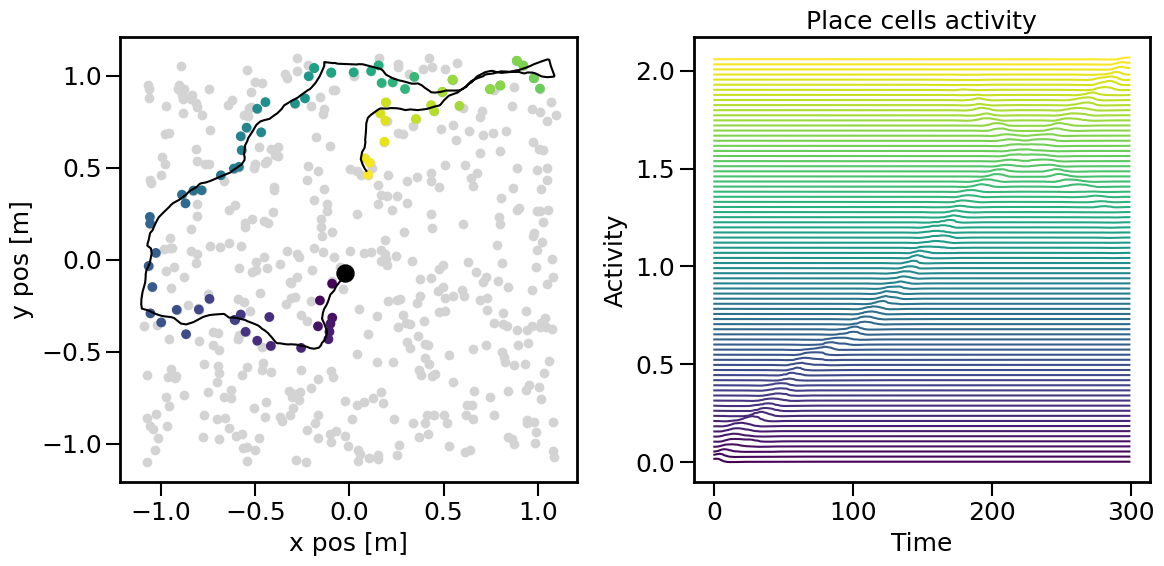

In [13]:
plot_n_cells = 100
raster = True  # Make raster-like plot
log_scale_activity = False

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = plot_trajectory_place_cells_activity(place_cells_center=place_cells_positions, 
                                                place_cell_activity=pc_rates_trajectories, 
                                                trajectory=trajectory, 
                                                ax1=ax1, 
                                                ax2=ax2, 
                                                plot_n_cells=plot_n_cells,
                                                log_scale=log_scale_activity,
                                                raster=raster)
plt.tight_layout()
plt.show()

In [14]:
# Get place cells rate map
pc_outputs_np = pc_outputs.reshape(-1, n_place_cells).detach().cpu().numpy()
pc = place_cells.grid_pc(pc_outputs_np[::100], res=100)

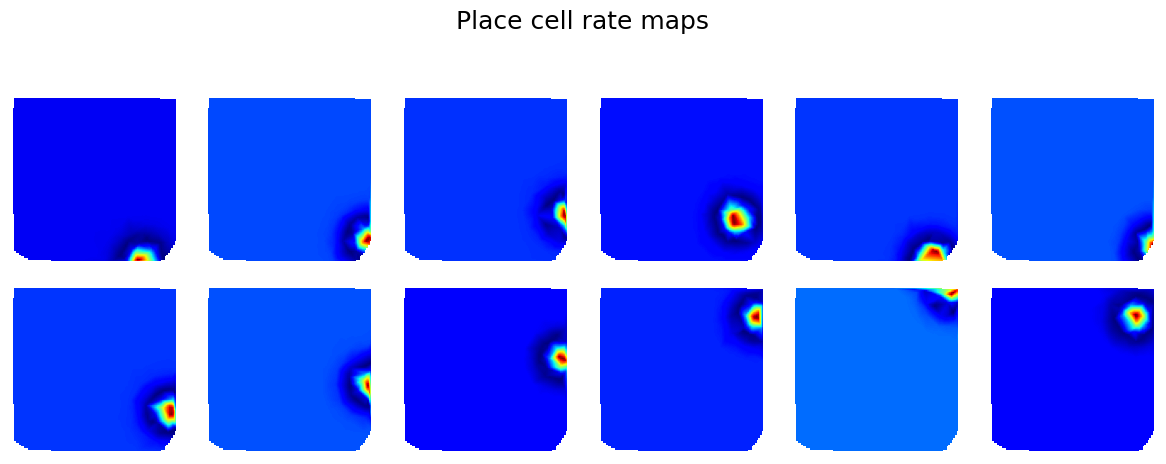

In [15]:
f, ax = plt.subplots(2, 6, figsize=(12, 5))
ax = ax.flatten()
for i in range(12):
    ax[i].imshow(pc[i], cmap="jet")
    ax[i].axis("off")
plt.suptitle("Place cell rate maps")
plt.tight_layout()
plt.show()

# Show trajectory for different batches

In [16]:
# Now we try shorter sequences to train an RNN using backpropagation through time
# Training will be done with short sequences
sequence_length = 20
batch_size = 256

In [17]:
generator = TrajectoryGenerator(sequence_length, batch_size, room_width, room_depth, device, place_cells=place_cells)
traj = generator.generate_trajectory(room_width, room_depth, batch_size)
x, y = traj["target_x"], traj["target_y"]

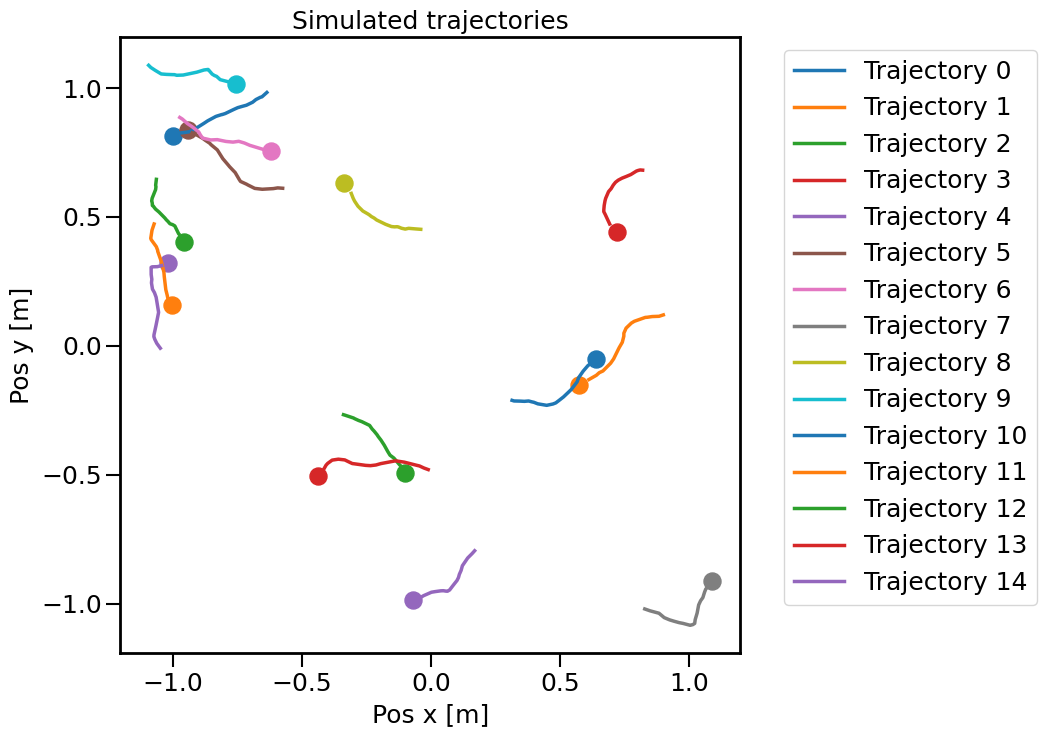

In [18]:
# Plotting options
plot_n_trajectories = 15
figure_size = (8, 8)
line_width = 2.5
marker_size = 150

# Plot trajectories
fig, ax = plt.subplots(1, 1, figsize=figure_size)
for i in range(plot_n_trajectories):
    init_x = traj["init_x"][i]
    init_y = traj["init_y"][i]
    ax.plot(x[i, :], y[i, :], label=f"Trajectory {i}", linewidth=line_width)
    ax.scatter(init_x, init_y, color=f"C{i}", marker="o", s=marker_size)
ax.set_xlabel("Pos x [m]")
ax.set_ylabel("Pos y [m]")
ax.set_title("Simulated trajectories")
# Putting the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Intro to RNNs
- Write equations for RNN
- Explain path integration problem
- Explain a bit of the idealized RNN
- Explain backpropagation through time

# Ideal RNN
# This is the code used by Burak, it is not the implementation described in Sorscher paper, but we can still make the same plots as in Sorscher paper, see below
# You can find all functions in neuralplayground/agents/burak2009.py

In [19]:
ideal_RNN = Burak2009(n_neurons=2**7, compute_sorscher_weights=False)
# help(Burak2009)

In [20]:
non_periodic_grid_cell = ideal_RNN.ideal_grid_cells(periodic_boundary = False)
periodic_grid_cell = ideal_RNN.ideal_grid_cells(periodic_boundary = True)

In [21]:
periodic_grid_cell.shape

(128, 128)

Text(0.5, 1.0, 'Zoomed')

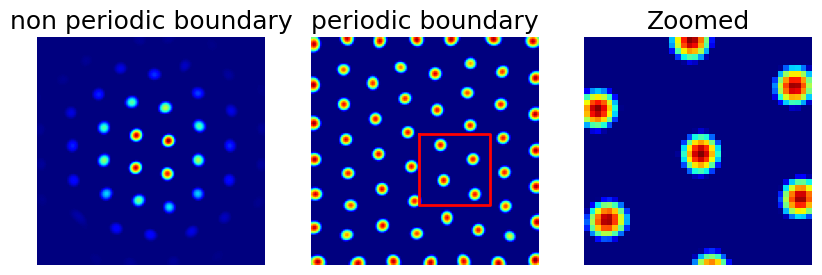

In [22]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(non_periodic_grid_cell, cmap="jet")
ax[0].axis("off")
ax[0].set_title("non periodic boundary")

ax[1].imshow(periodic_grid_cell, cmap="jet")
ax[1].axis("off")
ax[1].set_title("periodic boundary")

square_center = 80, 74
half_square_size = 20
# Draw a red square around square center of size 10 by 10
ax[1].plot([square_center[0]-half_square_size, square_center[0]+half_square_size, square_center[0]+half_square_size, square_center[0]-half_square_size, square_center[0]-half_square_size],
           [square_center[1]-half_square_size, square_center[1]-half_square_size, square_center[1]+half_square_size, square_center[1]+half_square_size, square_center[1]-half_square_size], color="red", linewidth=2)

# Imshow the activity of the grid cell just within the square
ax[2].imshow(periodic_grid_cell[square_center[0]-half_square_size:square_center[0]+half_square_size, 
                                square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
ax[2].axis("off")
ax[2].set_title("Zoomed")

# Changes in pattern of activity for constant velocity to the right
# Like Figure 1C in https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1000291&type=printable

# or Figure 5B in https://www.cell.com/neuron/pdf/S0896-6273(22)00907-2.pdf

## Constant velocity to the right

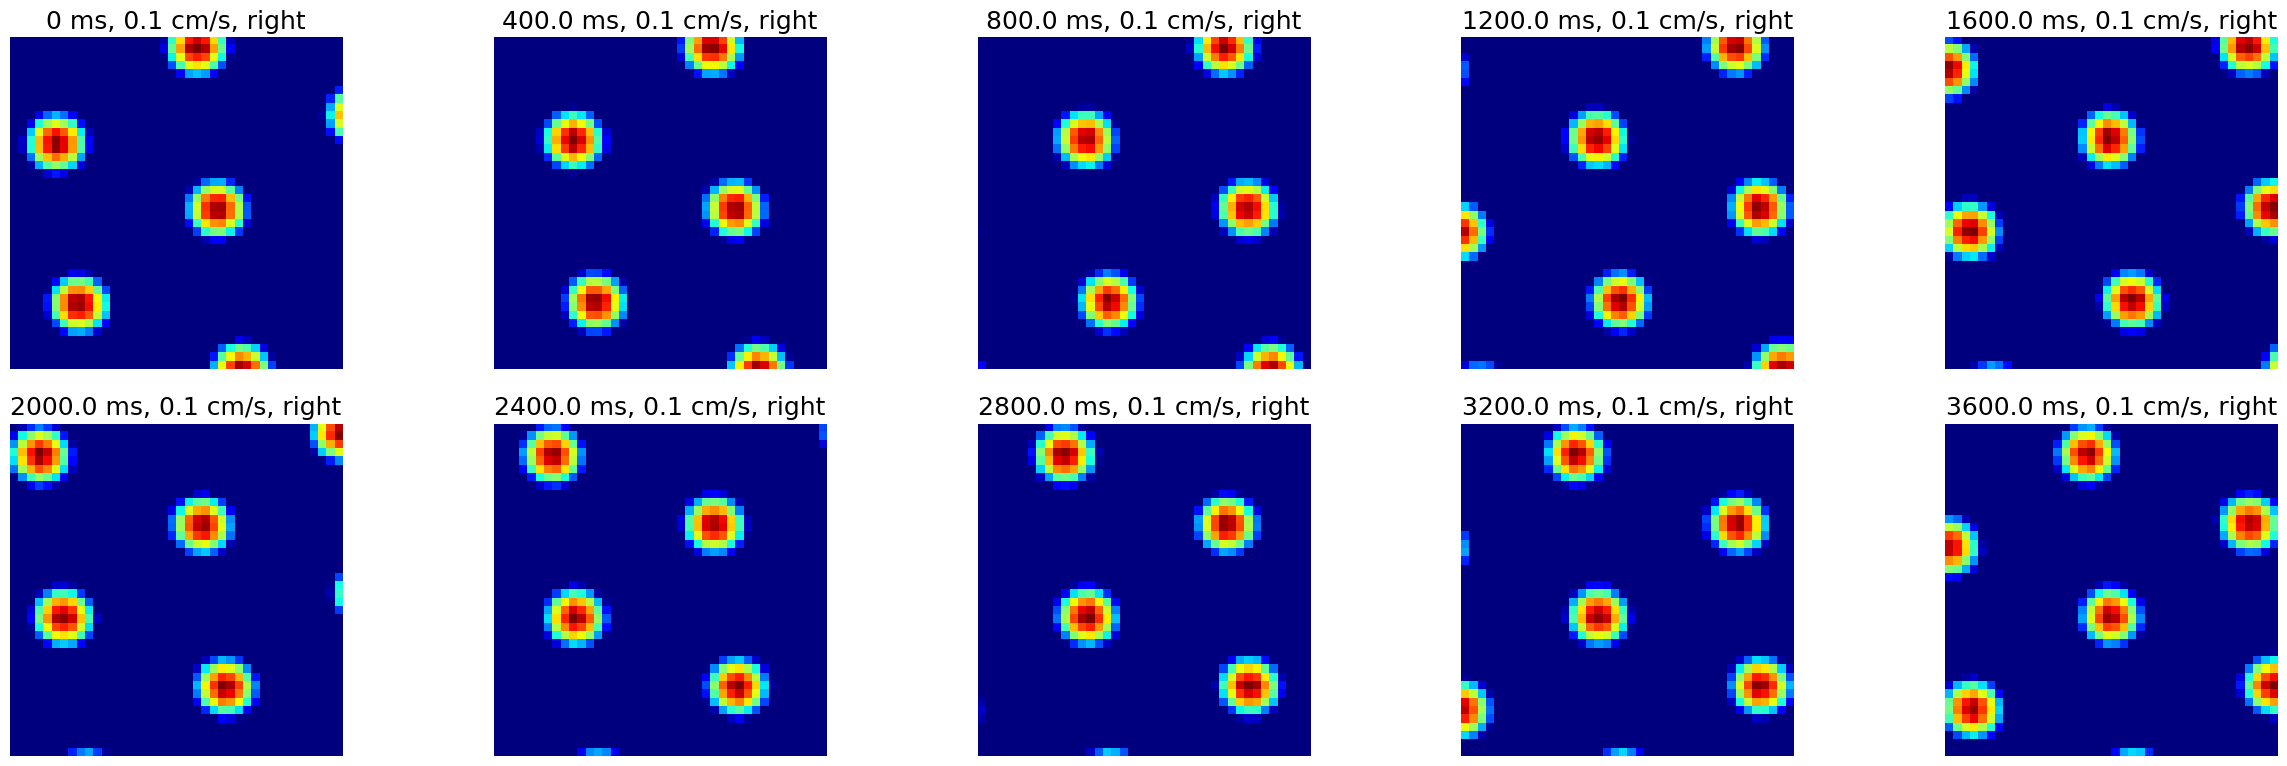

In [23]:
n_steps = 10
inner_steps = 800  # Since dt = 0.5ms, these are 400ms
velocity_size = 0.1  # 1cm/s

f, ax = plt.subplots(2, 5, figsize=(5*n_steps//2, 4*2))
ax = ax.flatten()

neuron_response = periodic_grid_cell
time = 0
for i in range(n_steps):
    neuron_response = ideal_RNN.update_rate_map(headDirection=np.zeros(inner_steps), # Head direction is in radians, so this is moving to the right
                                                velocity=np.ones(inner_steps)*0.01, 
                                                grid_cell_rate=neuron_response)
    ax[i].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size, 
                                 square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
    ax[i].set_title(f"{time} ms, {velocity_size} cm/s, right")
    time += ideal_RNN.time_step_dt*inner_steps
    ax[i].axis("off")
plt.tight_layout()
plt.show()

# Constant velocity up

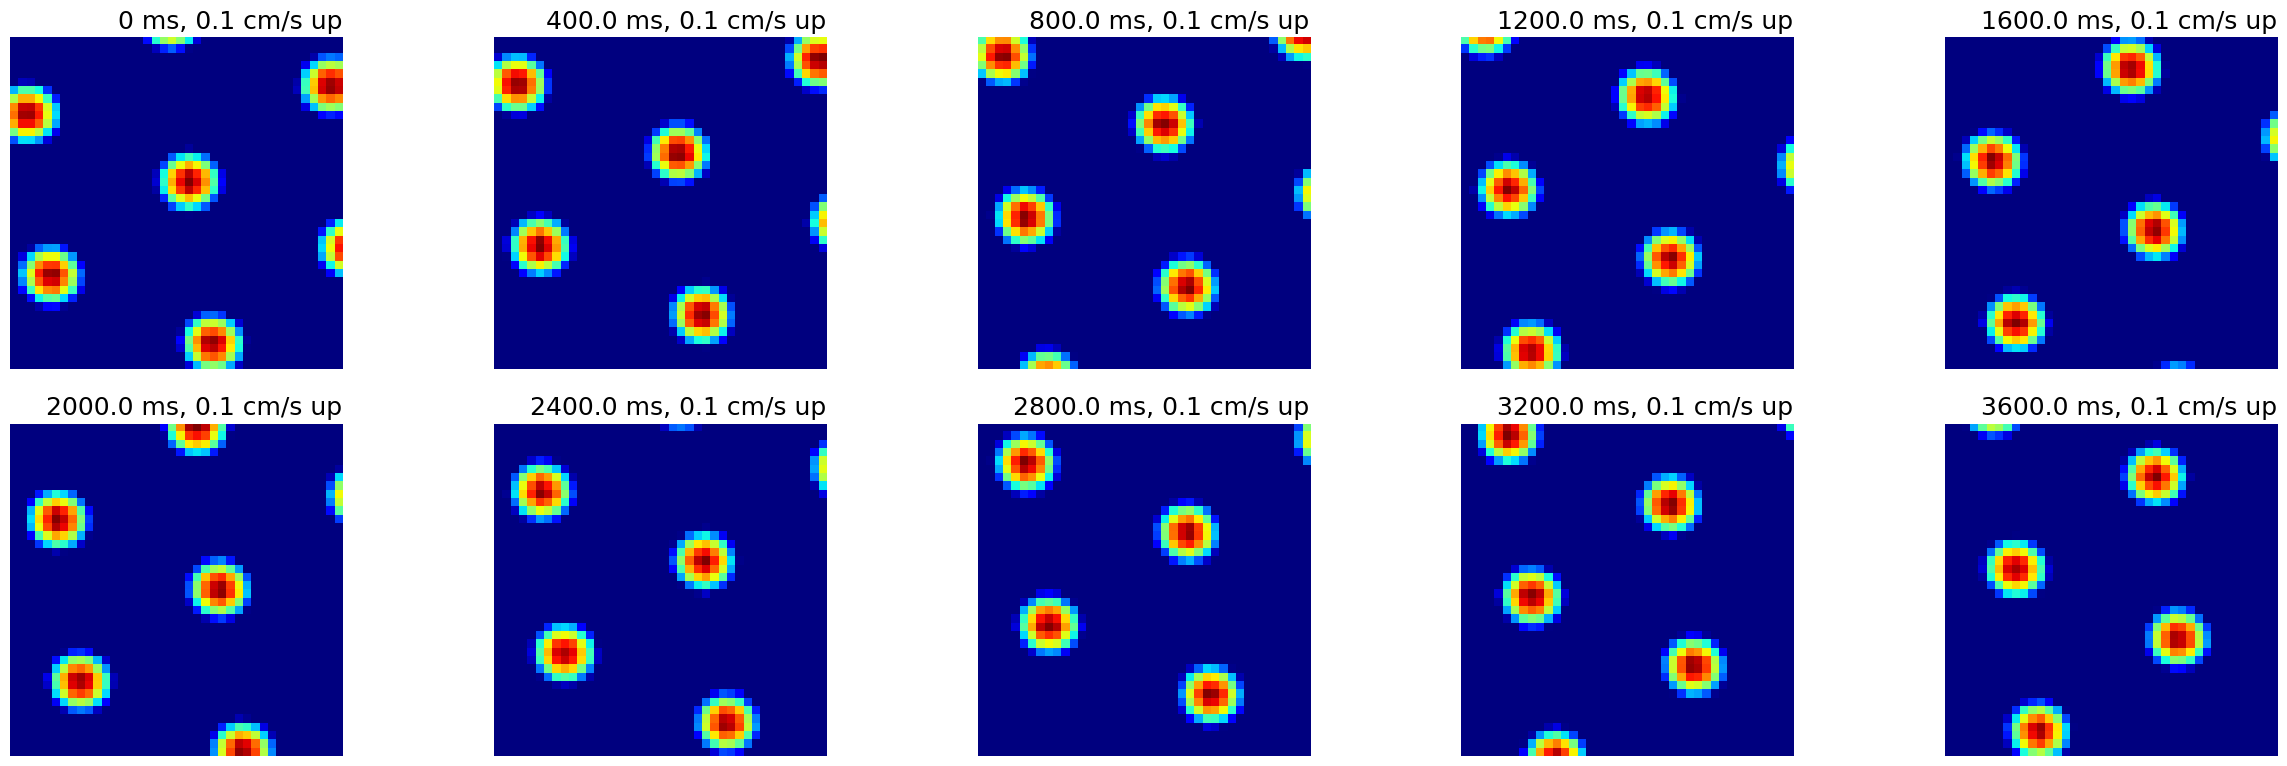

In [24]:
n_steps = 10
inner_steps = 800  # Since dt = 0.5ms, these are 400ms
velocity_size = 0.1  # 1cm/s

f, ax = plt.subplots(2, 5, figsize=(5*n_steps//2, 4*2))
ax = ax.flatten()

neuron_response = periodic_grid_cell
time = 0
for i in range(n_steps):
    neuron_response = ideal_RNN.update_rate_map(headDirection=np.ones(inner_steps)*np.pi/2, # Head direction is in radians, so this is moving up
                                                velocity=np.ones(inner_steps)*0.01, 
                                                grid_cell_rate=neuron_response)
    ax[i].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size, 
                                 square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
    ax[i].set_title(f"{time} ms, {velocity_size} cm/s up", loc="right")
    time += ideal_RNN.time_step_dt*inner_steps
    ax[i].axis("off")
plt.tight_layout()
plt.show()

# All directions as in Figure 6D for the ideal network

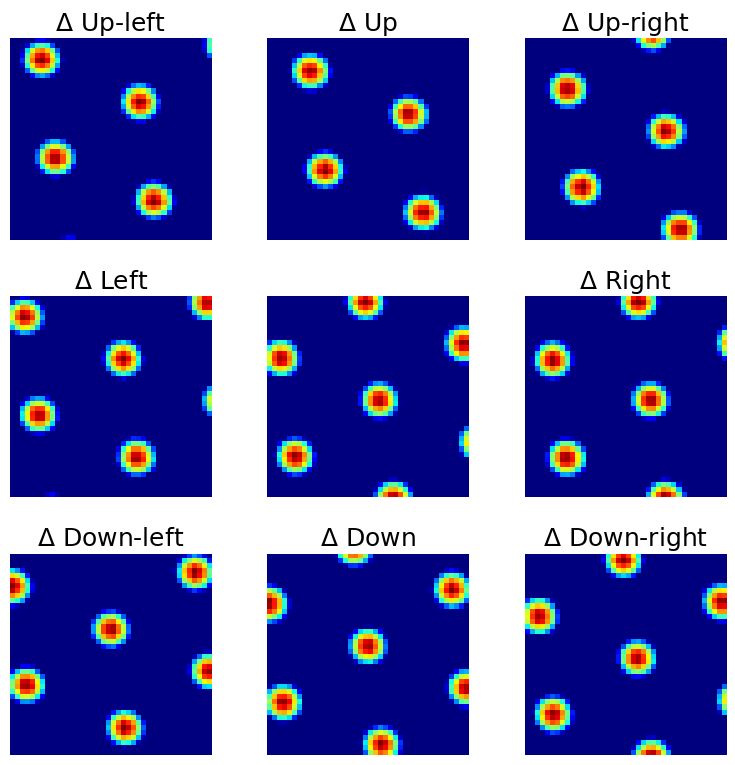

In [25]:
inner_steps = 800  # Since dt = 0.5ms, these are 400ms
velocity_size = 0.1  # 1cm/s

f, ax = plt.subplots(3, 3, figsize=(8, 8))

neuron_response = periodic_grid_cell
time = 0
response_per_direction = []

# Head directions in radians
head_directions = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
# Just a list with axis indexes to plot the rates in neural sheet space
subplot_coordinates = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
dir_titles = ["Right", "Up-right", "Up", "Up-left", "Left", "Down-left", "Down", "Down-right"]


for i in range(len(head_directions)):
    hd = head_directions[i]
    axi, axj = subplot_coordinates[i]
    neuron_response = ideal_RNN.update_rate_map(headDirection=np.ones(inner_steps)*hd, # Head direction is in radians, so this is moving up
                                                  velocity=np.ones(inner_steps)*0.01, 
                                                  grid_cell_rate=neuron_response)
    ax[axi, axj].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size, 
                                        square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
    ax[axi, axj].axis("off")
    # Draw an arrow from the central plot to the next plot according to its head direction
    ax[axi, axj].set_title("$\Delta$ "+dir_titles[i], loc="center")
ax[1, 1].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size, 
                                 square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
ax[1, 1].axis("off")
plt.tight_layout()
plt.show()

# $\Delta$ as in figure 6B for the ideal network

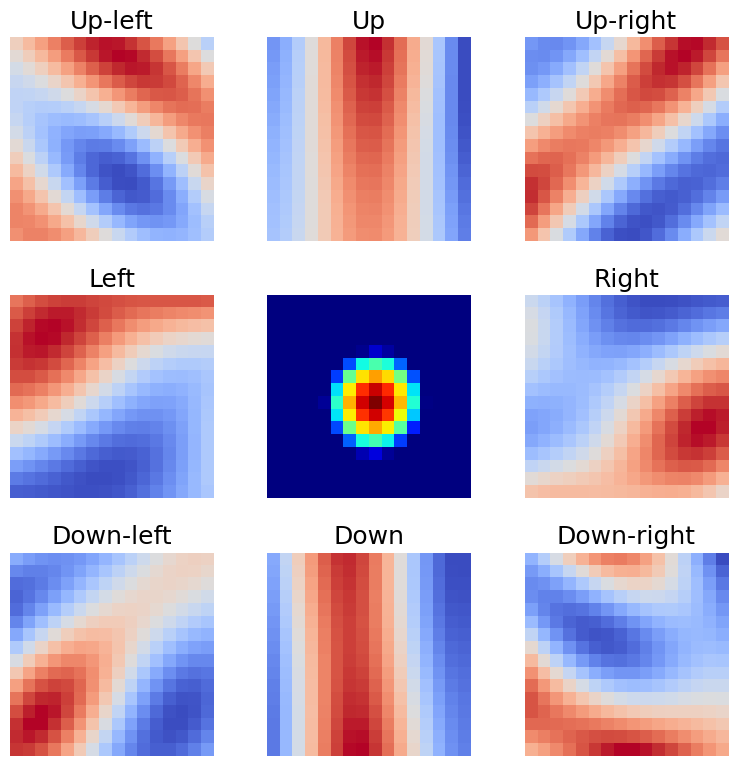

In [26]:
inner_steps = 800  # Since dt = 0.5ms, these are 400ms
velocity_size = 0.1  # 1cm/s

f, ax = plt.subplots(3, 3, figsize=(8, 8))

neuron_response = periodic_grid_cell
time = 0
response_per_direction = []

# Head directions in radians
head_directions = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
# Just a list with axis indexes to plot the rates in neural sheet space
subplot_coordinates = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
dir_titles = ["Right", "Up-right", "Up", "Up-left", "Left", "Down-left", "Down", "Down-right"]

square_center = 80, 74
half_square_size = 8
for i in range(len(head_directions)):
    hd = head_directions[i]
    axi, axj = subplot_coordinates[i]
    _, pattern_change = ideal_RNN.update_rate_map(headDirection=np.ones(inner_steps)*hd, # Head direction is in radians, so this is moving up
                                                  velocity=np.ones(inner_steps), 
                                                  grid_cell_rate=neuron_response,
                                                  get_pattern_change=True)
    ax[axi, axj].imshow(pattern_change[square_center[0]-half_square_size:square_center[0]+half_square_size, 
                                     square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="coolwarm")
    ax[axi, axj].axis("off")
    # Draw an arrow from the central plot to the next plot according to its head direction
    ax[axi, axj].set_title(dir_titles[i], loc="center")
ax[1, 1].imshow(neuron_response[square_center[0]-half_square_size:square_center[0]+half_square_size, 
                                 square_center[1]-half_square_size:square_center[1]+half_square_size], cmap="jet")
ax[1, 1].axis("off")
plt.tight_layout()
plt.show()

In [27]:
# Generate a trajectory following base code to get the same results
# This trajectory is simulated using an enclosure radios of 2 meters
example_trajectory_size = 100000
position_x, position_y, headDirection = ideal_RNN.simulate_base_trajectory(sequence_length=example_trajectory_size)

100%|██████████| 100000/100000 [00:04<00:00, 20921.54it/s]


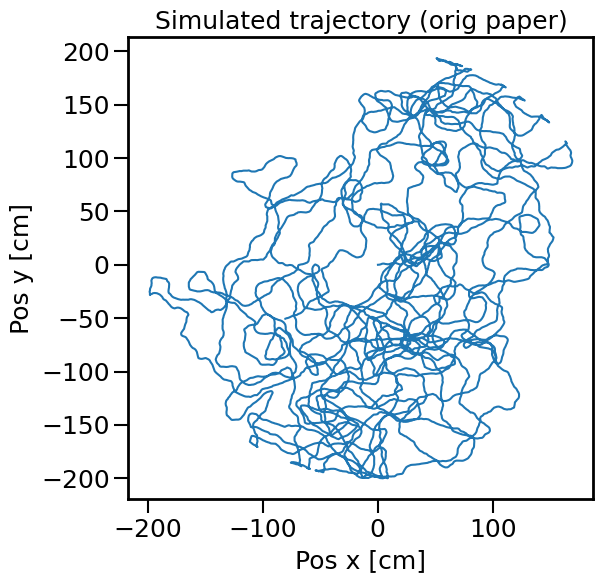

In [28]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(position_x, position_y)
ax.set_xlabel("Pos x [cm]")
ax.set_ylabel("Pos y [cm]")
ax.set_title("Simulated trajectory (orig paper)")
plt.show()

In [29]:
use_periodic = False
if use_periodic:
    grid_rate = periodic_grid_cell
else:
    grid_rate = non_periodic_grid_cell
neuron_response, grid_rate = ideal_RNN.path_neural_activity(position_x,
                                                            position_y, 
                                                            headDirection, 
                                                            grid_rate,
                                                            periodic_boundary=use_periodic)

100%|██████████| 99980/99980 [02:48<00:00, 592.38it/s]


In [30]:
np.unique(neuron_response), np.max(neuron_response), np.min(neuron_response)

(array([0.00000000e+00, 2.55117984e-05, 6.98724453e-05, ...,
        6.70929281e-01, 6.73949654e-01, 6.80820961e-01]),
 0.680820960578543,
 0.0)

# Figure 2B in https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1000291&type=printable

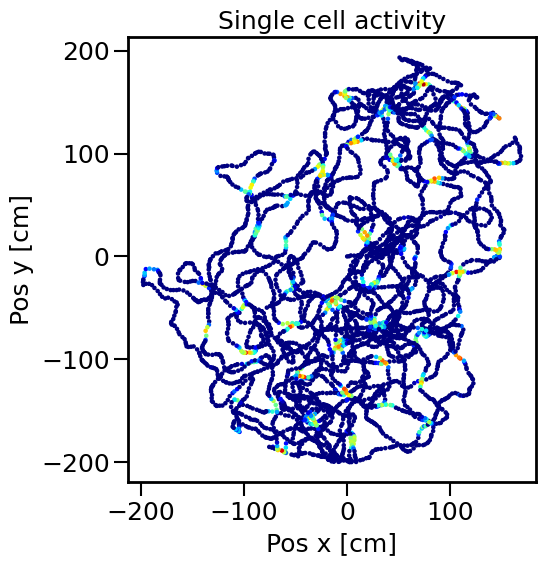

In [31]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
#ax[0].plot(position_x, position_y)
ax.set_xlabel("Pos x [cm]")
ax.set_ylabel("Pos y [cm]")
ax.set_title("Single cell activity")

sub_sample_index = np.arange(0, len(neuron_response), 20)
activitiy_rate_sampled = neuron_response[sub_sample_index]
subsample_x = position_x[sub_sample_index]
subsample_y = position_y[sub_sample_index]
colors = plt.cm.jet(neuron_response/np.max(neuron_response))
subsample_colors = colors[sub_sample_index]

ax.scatter(subsample_x, subsample_y, c=subsample_colors, s=5)
ax.axis("equal")

plt.tight_layout()
plt.show()

# Plot neuron location and connectivity of an idealized path integrator (This is not the same model as above (Burak and Fiete), the one below are the equations 35, 36 and 37 from Sorscher paper)

In [32]:
# Computing Sorscher weights is just for plotting purposes
ideal_RNN = SorscherIdealRNN(n_neurons=24**2)

Building recurrent matrix


## I realized the velocity input weights based on neural sheet position is not correct in the paper (paragraph right after eq 37), which is written as
- sheet location: $ s_{i} = \left(p, q\right)^{T} $
- Horizontal velocity input weights: $ M_{ix}=\text{mod}_{2}(q)\cdot(-1)^{p} $
- Vertical velocity input weights: $ M_{iy}=\text{mod}_{2}(p)\cdot(-1)^{q} $

Assuming $M_{ix}$, the proper pattern for vertical velocity weight is:
- Vertical velocity input weights: $ M_{iy}=\text{mod}_{2}(q+1)\cdot(-1)^{p} $

In [33]:
Jij = ideal_RNN.Jij
Mixy = ideal_RNN.Mixy
sheet_locations = ideal_RNN.sheet_locations

Text(0.5, 1.0, 'Location in neural sheet')

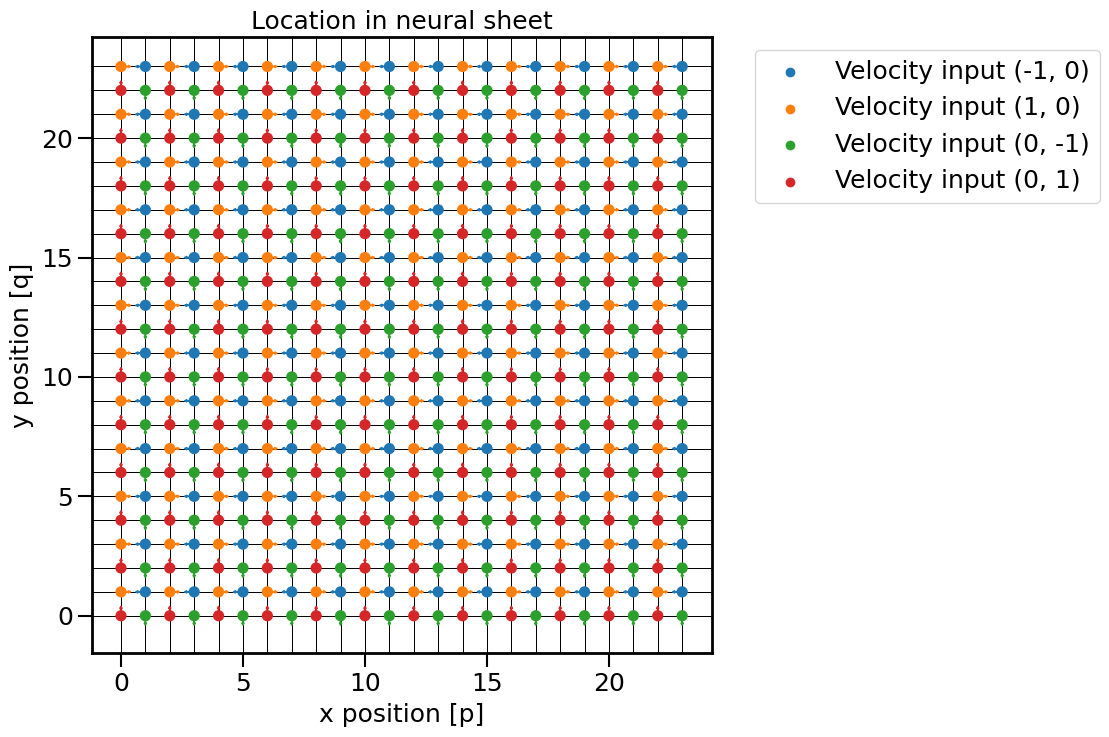

In [34]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))

# First draw vertical lines for each neuron, such that the intersection correspondes to the neuron location, and put them behind the neurons
for i in range(ideal_RNN.n_neurons):
    ax.axvline(sheet_locations[i, 0], color="black", linewidth=0.5, zorder=0, alpha=0.5)
    ax.axhline(sheet_locations[i, 1], color="black", linewidth=0.5, zorder=0, alpha=0.5)

# Just colouring each neuron based on its velocity input weights
colors = []
colors_id = {(-1, 0): "C0", (1, 0): "C1", (0, -1): "C2", (0, 1): "C3"}
for i in range(ideal_RNN.n_neurons):
    colors.append(colors_id[(Mixy[i, 0], Mixy[i, 1])])
ax.scatter(sheet_locations[:, 0], sheet_locations[:, 1], c=colors, s=50)
# Draw small arrow for each neuron, pointing in the direction of Mixy
arrow_size = 0.3
for i in range(ideal_RNN.n_neurons):
    ax.arrow(sheet_locations[i, 0], sheet_locations[i, 1], Mixy[i, 0]*arrow_size, Mixy[i, 1]*arrow_size, head_width=0.1, head_length=0.1, color=colors[i])

# Adding a legend outside indicating direction based on the color
for key, value in colors_id.items():
    ax.scatter([], [], c=value, label=f"Velocity input {key}")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel("x position [p]")
ax.set_ylabel("y position [q]")
ax.set_title("Location in neural sheet")

# Take some neurons and show its connections in neural sheet space
# Figure 5C

In [35]:
central_neuron_id = np.where(np.logical_and(sheet_locations[:, 0] == ideal_RNN.L//2, sheet_locations[:, 1] == ideal_RNN.L//2))[0][0]
random_neuron1 = np.random.randint(0, ideal_RNN.n_neurons)
random_neuron2 = np.random.randint(0, ideal_RNN.n_neurons)

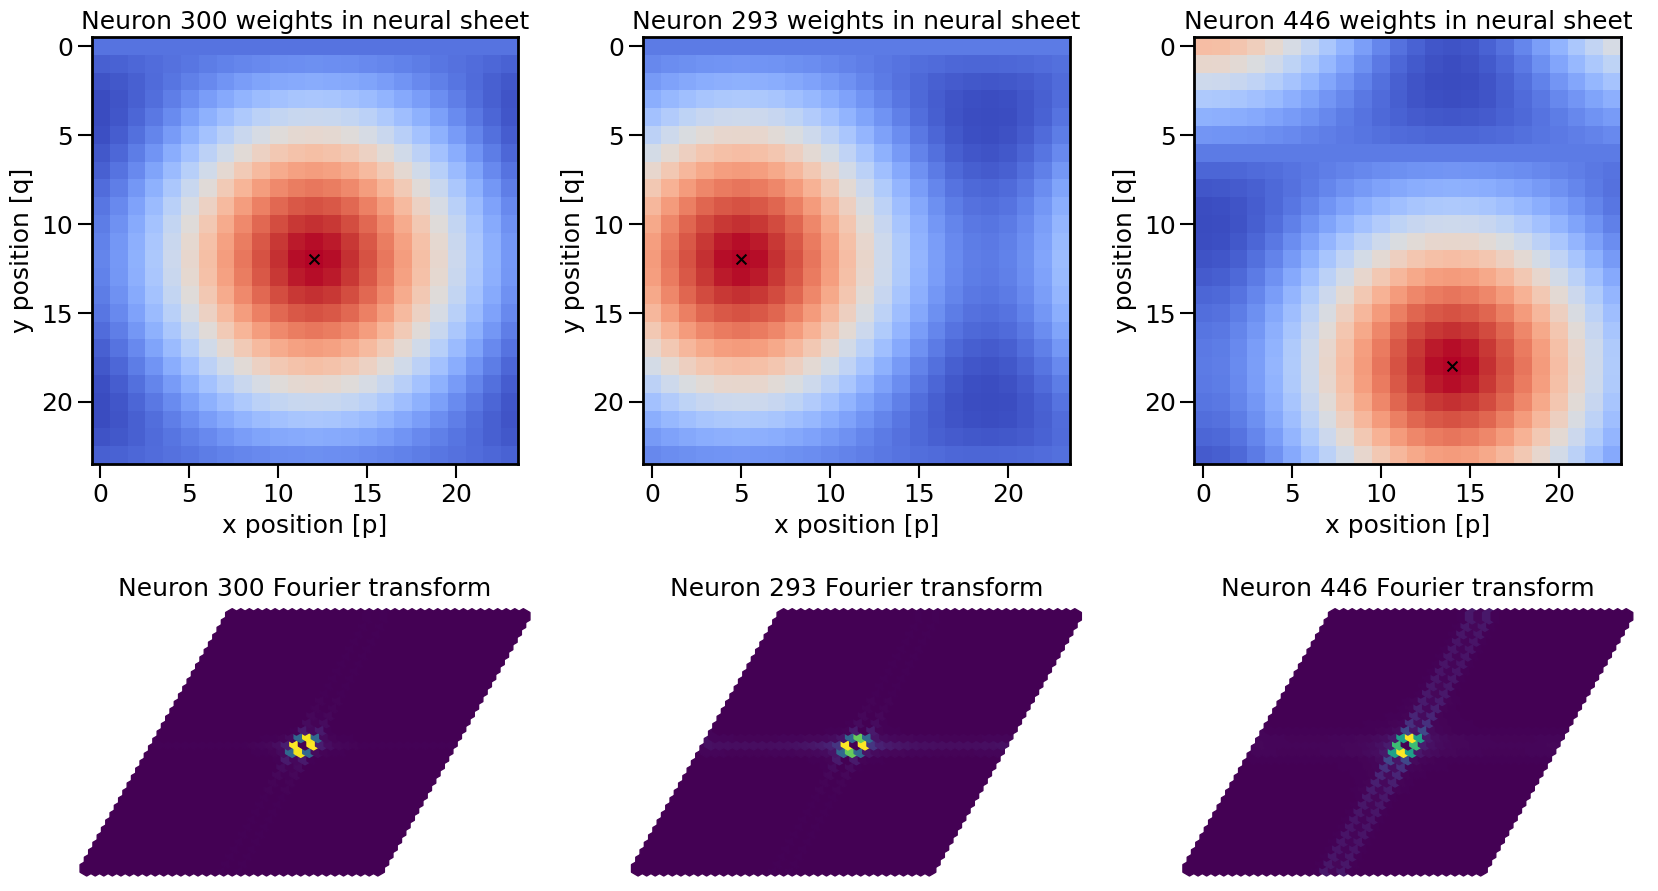

In [36]:
f, ax = plt.subplots(2, 3, figsize=(17, 10))
for i, neuron_id in enumerate([central_neuron_id, random_neuron1, random_neuron2]):
    ax[0, i].imshow(Jij[neuron_id, :].reshape(24, 24), cmap="coolwarm")
    # Add a cross in the location of the neuron
    ax[0, i].scatter(sheet_locations[neuron_id, 1], sheet_locations[neuron_id, 0], c="black", s=50, marker="x")
    ax[0, i].set_title(f"Neuron {neuron_id} weights in neural sheet")
    ax[0, i].set_xlabel("x position [p]")
    ax[0, i].set_ylabel("y position [q]")

# Below show the fourier transform in an exagonal grid of the weights
for i, neuron_id in enumerate([central_neuron_id, random_neuron1, random_neuron2]):
    n = int(ideal_RNN.L)
    width = 18
    xs = np.arange(2*width-1)
    X,Y = np.meshgrid(xs,xs)
    XY = np.stack((X.ravel(),Y.ravel()),0)
    T = np.array([[1,0.5],[0,np.sqrt(3)/2]])
    XY = T.dot(XY)#+ np.random.randn(*XY.shape)/100 
    
    idxs = np.arange(-width+1, width)
    im_fft = np.abs(np.fft.fft2(Jij[neuron_id].reshape(24, 24)))
    im_fft[0,0] = 0
    
    ax[1, i].scatter(XY[0],XY[1],s=120,c=im_fft[idxs][:,idxs].ravel(),
                marker='h', cmap='viridis')
    ax[1, i].set_aspect('equal')
    ax[1, i].set_axis_off()
    ax[1, i].set_title(f"Neuron {neuron_id} Fourier transform")
plt.tight_layout()
plt.show()

# Figure 5D  (not sure why is not as clean as in the paper, maybe because the number of neurons?)

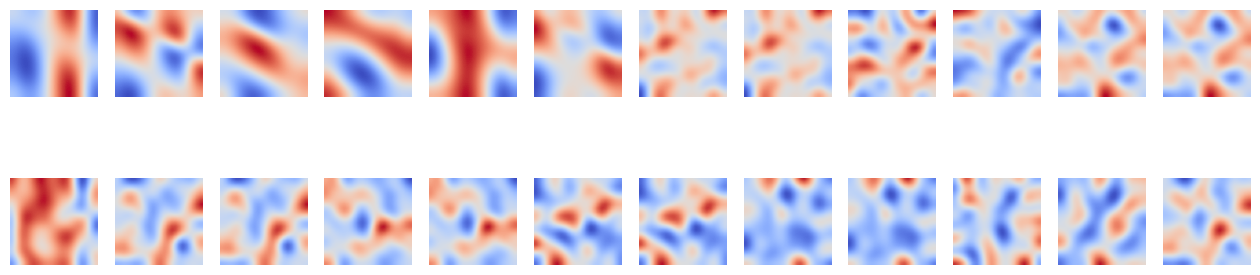

In [37]:
eigs, eigvs = np.linalg.eig(Jij)
U,S,V = np.linalg.svd(Jij)

A = np.asarray([[2,1],[0, np.sqrt(3)]])/2
Ainv = np.linalg.inv(A)

idxs = np.flip(np.argsort(eigs))

A = np.asarray([[2,1],[0, np.sqrt(3)]])/2
Ainv = np.linalg.inv(A)

# n = int(np.sqrt(2**7))
n = int(np.sqrt(24**2))
plt.figure(figsize=(16,4))
for i in range(24):
    plt.subplot(2,12,i+1)
    idx = idxs[i]
    im = np.real(eigvs[:,idx].reshape(n,n))
    im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
    im = scipy.ndimage.gaussian_filter(im, sigma=(2,2))
    plt.imshow(im, cmap='coolwarm', interpolation='gaussian')
    plt.axis('off')

# Initialize and train RNN, everything is smaller than in the original paper so people can run it in their own computers

In [73]:
# Real RNN parameters
# Pre-trained models use this number of neurons
n_grid_cells = 24**2  # needs to be the square of a number for later analysis
# n_grid_cells = 64**2
learning_rate = 5e-4
training_steps = int(1e5)
weight_decay = 1e-4
sequence_length = 20

# If you are loading a pre-trained model, make sure to use the same activation function
activation = "relu"  # This will give you "square grids", some of them actually look hexagonal
# activation = "relu"  # This will give you hexagonal grids

In [74]:
# We can apply "next" operator to sample trajectory batches and place cells activity 
gen = generator.get_batch_generator()

# Trained RNN

In [75]:
real_rnn = Sorscher2022exercise(Ng=n_grid_cells,
                                Np=n_place_cells,
                                sequence_length=sequence_length,
                                weight_decay=weight_decay,
                                place_cells=place_cells,
                                activation=activation,
                                learning_rate=learning_rate)

In [76]:
# Remove coment below if you want to re-train
# loss_hist, pos_err_hist = real_rnn.train_RNN(gen, training_steps)

In [77]:
# Save model 
# real_rnn.save_model("tmp_tutorial_model/trained_model")

## Use a pre-trained model if you like, Make sure you use the same non-linearity when initializing the model

In [78]:
# Load pre-trained model
real_rnn.load_model("tmp_tutorial_model/pre_trained_relu")
# real_rnn.load_model("tmp_tutorial_model/pre_trained_tanh")

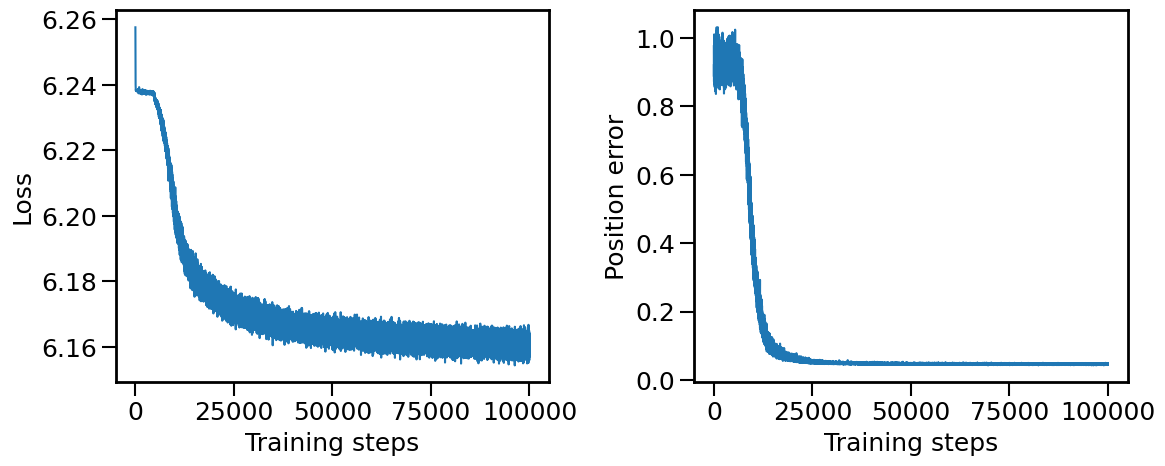

In [79]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(real_rnn.loss_hist)
ax[0].set_xlabel("Training steps")
ax[0].set_ylabel("Loss")

ax[1].plot(real_rnn.pos_err_hist)
ax[1].set_xlabel("Training steps")
ax[1].set_ylabel("Position error")
plt.tight_layout()
plt.show()

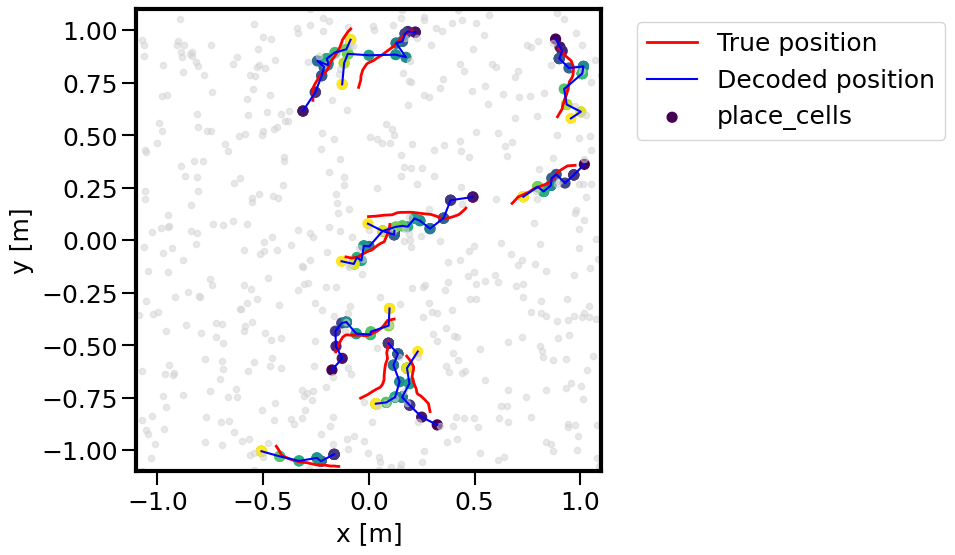

In [111]:
n_trajectories = 10
inputs, pos, pc_outputs = generator.get_test_batch()
#inputs: tuple with velocity and initial place cell activity with shapes [seq_len, batch, 2] and [batch, Np].

pos = pos.cpu()
pred_pos = place_cells.get_nearest_cell_pos(real_rnn.predict(inputs)).cpu()
us = place_cells.cell_positions.cpu()
colors = plt.cm.viridis(np.linspace(0, 1, sequence_length))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(n_trajectories):
    ax.plot(pos[:,i,0], pos[:,i,1], c='red', label='True position', linewidth=2)
    ax.plot(pred_pos[:,i,0], pred_pos[:,i,1],
             c="blue", label='Decoded position')
    ax.scatter(pred_pos[:,i,0], pred_pos[:,i,1], c=colors, s=50, label='place_cells')
    if i==0:
        # Locate the legend outside the plot
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.scatter(us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_xlim([-room_depth/2,room_width/2])
ax.set_ylim([-room_depth/2,room_depth/2]);

In [113]:
velocities, initial_place_activity = inputs
print("Velocities shape", velocities.shape)
print("Initial place activity shape", initial_place_activity.shape)
print("Place cell activity shape", pc_outputs.shape)
print("Position shape", pos.shape)

Velocities shape torch.Size([20, 256, 2])
Initial place activity shape torch.Size([256, 512])
Place cell activity shape torch.Size([20, 256, 512])
Position shape torch.Size([20, 256, 2])


In [114]:
res = 50
n_avg = 100
Ng = n_grid_cells
activations, rate_map, g, pos = compute_ratemaps(real_rnn,
                                                 generator,
                                                 sequence_length,
                                                 batch_size,
                                                 room_width,
                                                 room_depth,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=n_grid_cells)

In [115]:
print("Activations shape", activations.shape)
print("Rate map shape", rate_map.shape)
print("g shape", g.shape)
print("Position shape", pos.shape)


Activations shape (576, 50, 50)
Rate map shape (576, 2500)
g shape (512000, 576)
Position shape (512000, 2)


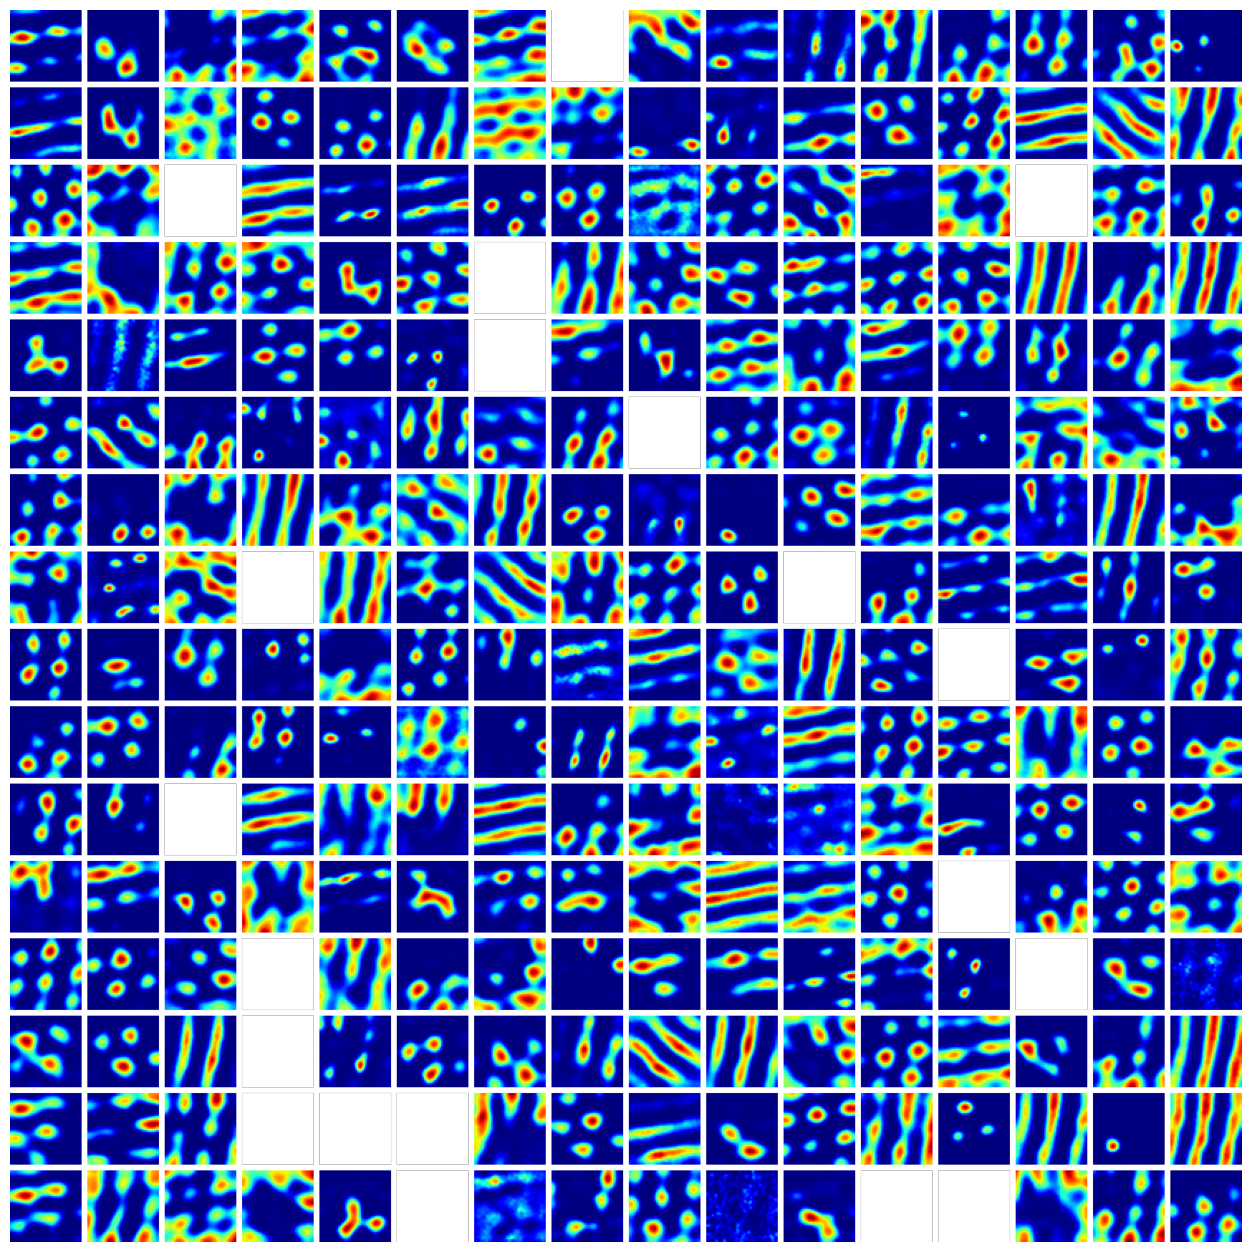

In [116]:
n_plot = 256
plt.figure(figsize=(16, 4*n_plot//8**2))

# See original plotting function in vendored code
# Neuralplayground/vendored/visualize.py
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');

# Sorting RNN units onto a neural sheet (from eq 39 to 42) in Sorscher paper

In [85]:
# Fourier transform 
Ng = n_grid_cells
rm_fft_real = np.zeros([Ng,res,res])
rm_fft_imag = np.zeros([Ng,res,res])

# Computing fourier transform to get phases
for i in tqdm(range(Ng)):
    rm_fft_real[i] = np.real(np.fft.fft2(rate_map[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(rate_map[i].reshape([res,res])))

rm_fft = rm_fft_real + 1j * rm_fft_imag

k1 = [3,0]
k2 = [2,3]
k3 = [-1,3]
k4=k5=k6=k1

freq = 1
# Equation 39 in Sorscher paper, spatial later assign a sheet position to each neuron
ks = freq*np.array([k1,k2,k3,k4,k5,k6])
ks = ks.astype('int')

modes = np.stack([rm_fft[:,k[0],k[1]] for k in ks])

100%|██████████| 576/576 [00:00<00:00, 7039.04it/s]


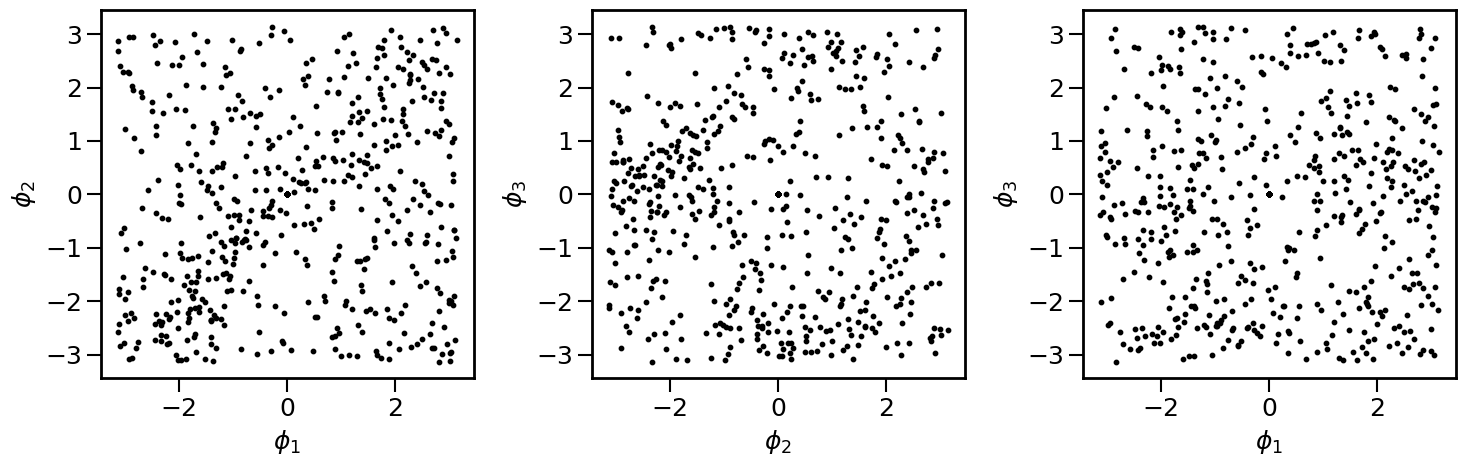

In [86]:
# Find phases
phases = [np.angle(mode) for mode in modes]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(phases[0], phases[1], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.subplot(132)
plt.scatter(phases[1], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_2$')
plt.ylabel(r'$\phi_3$')
plt.subplot(133)
plt.scatter(phases[0], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_3$')
plt.tight_layout()
plt.show()

# Following is Figure 4B of Sorscher paper

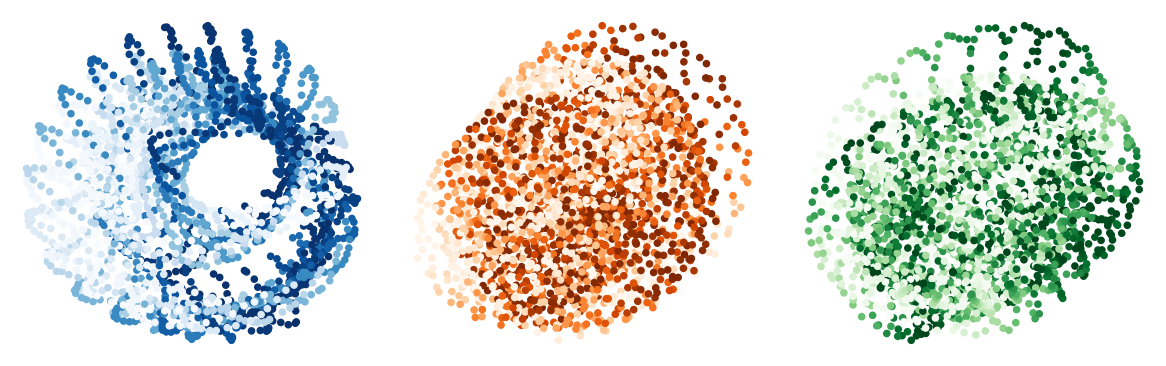

In [87]:

freq = 1
crop = 0
cmaps = ['Blues', 'Oranges', 'Greens']
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    B = np.stack([np.cos(phases[i]), np.sin(phases[i])])
    test = B@rate_map
    plt.scatter(test[0], test[1], c=X[i][idxs], cmap=cmaps[i], s=20)
    plt.axis('off')
plt.tight_layout()

# Sorting algorithm, see appendix, section "Sorting RNN units onto a neural sheet"

In [88]:
N = rate_map.shape[0]
n = int(np.sqrt(N))
width = int(np.sqrt(N))
freq = 1
X,Y = np.meshgrid(np.arange(width),np.arange(width))
X = X*2*np.pi/width
Y = Y*2*np.pi/width

s1 = np.zeros(phases[0].shape)
s2 = np.zeros(phases[0].shape)

fac = np.sqrt(3)/2

for i in range(Ng):
    penalty_1 = np.cos(freq*X - phases[0][i]/fac)
    penalty_2 = np.cos(freq*Y - phases[2][i]/fac)
    penalty_3 = np.cos(freq*(X+Y) - phases[1][i]/fac)
    ind = np.argmax(penalty_1+penalty_2 + penalty_3  + np.random.randn()/100)
    s1[i],s2[i] = np.unravel_index([ind],penalty_1.shape)
    
total_order = get_2d_sort(s1,s2)
rm_sort_square = rate_map[total_order.ravel()].reshape([n,n,-1])

/tmp/ipykernel_22681/1701089033.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1[i],s2[i] = np.unravel_index([ind],penalty_1.shape)


In [89]:
total_order

array([287, 261,  54, 541, 318, 317,  70, 258, 115, 439,  88, 463, 464,
       188, 270,  72, 288, 490, 282, 442, 259, 443, 446, 434, 195,  34,
       448,  45, 333, 122, 256, 251, 508, 245, 140, 229, 228, 227, 501,
       476, 162, 211, 205, 417, 138, 232, 148,  25, 369,   7, 555, 372,
       368, 356, 193, 197, 342, 520,  12, 569, 108,  20, 491, 563, 186,
        96, 470,  13, 213, 384, 133, 121, 420,   9, 394, 281,   4, 571,
       155, 164,  62, 347,  38,  68, 398, 220, 142, 489, 502, 113,  67,
       504, 505, 329,  26,  73, 201, 309, 145, 320,  49, 449, 431, 182,
        61, 304,  21,  93, 414, 266,  83, 543,  90, 362, 547,  23, 415,
       284,  47, 139, 315,  41, 422, 242, 312, 222, 493, 532,  76, 559,
       354,  94,  89, 424, 236, 355, 472,   1, 253,  44, 538, 200, 497,
       338, 277, 500, 468, 260, 389, 294, 123, 291, 177, 450, 275, 410,
       533, 124, 485, 361,  99, 426, 574, 128,   8, 477, 252, 212, 106,
       471, 528, 404, 433, 552, 346, 445, 152, 560, 527,   2,  5

Text(0.5, 1.0, 'J')

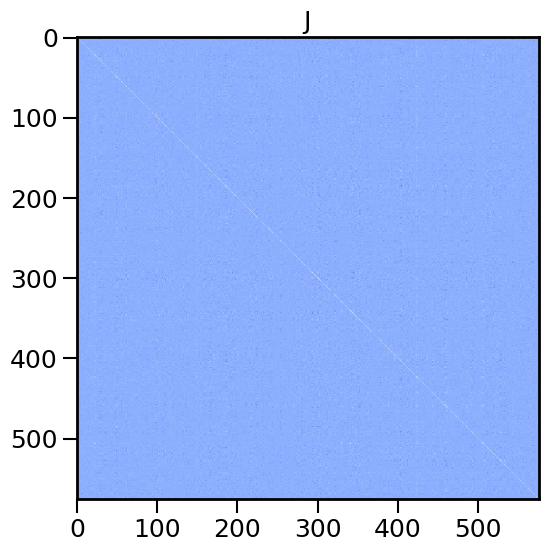

In [90]:
# Unsorted weight matrix
J = real_rnn.recurrent_W.detach().cpu().numpy()
plt.figure(figsize=(6,6))
plt.imshow(J, cmap='coolwarm')
plt.title('J')

# Figure 5J

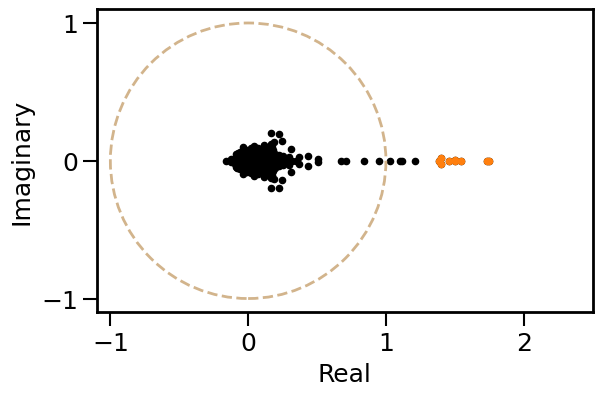

In [91]:
# Eigenvalues
eigs, eigvs = np.linalg.eig(J)

fig, ax = plt.subplots()
plt.scatter(np.real(eigs), np.imag(eigs), c='black', s=20)
plt.scatter(np.real(eigs[:9]), np.imag(eigs[:9]), c='C1', s=20)
circle1 = plt.Circle((0, 0), 1, color='tan',
                     fill=False, linestyle='dashed', linewidth=2)
ax.add_artist(circle1)
plt.xlim([-1.1,2.5])
plt.ylim([-1.1,1.1])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.gca().set_aspect('equal', adjustable='box')
plt.locator_params(nbins=4)
# plt.axis('equal')
# sns.despine()
# plt.savefig('images/final_eigs.pdf')

Text(0.5, 0, 'Index')

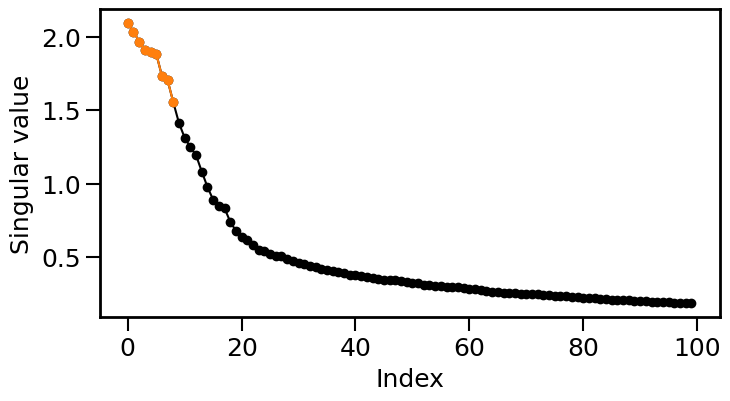

In [92]:
U,S,V = np.linalg.svd(J)

plt.figure(figsize=(8,4))
plt.plot(S[:100], 'o-', c='black')
plt.plot(S[:9], 'o-', c='C1')
plt.ylabel('Singular value')
plt.xlabel('Index')
# sns.despine();

# Figure 5H of Sorscher paper

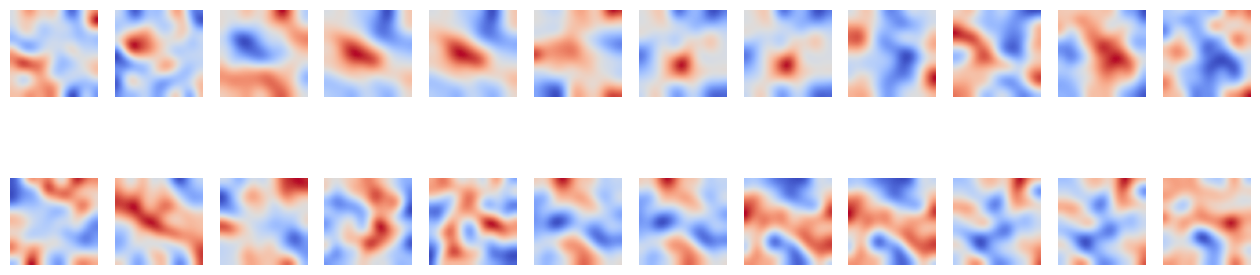

In [93]:
idxs = np.flip(np.argsort(eigs))

A = np.asarray([[2,1],[0, np.sqrt(3)]])/2
Ainv = np.linalg.inv(A)

n = int(np.sqrt(Ng))
plt.figure(figsize=(16,4))
for i in range(24):
    plt.subplot(2,12,i+1)
    idx = idxs[i]
    im = np.real(eigvs[total_order,idx].reshape(n,n))
    im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
    im = scipy.ndimage.gaussian_filter(im, sigma=(2,2)) 
    plt.imshow(im, cmap='coolwarm', interpolation='gaussian')
    plt.axis('off')

# Figure 5G of Sorscher paper

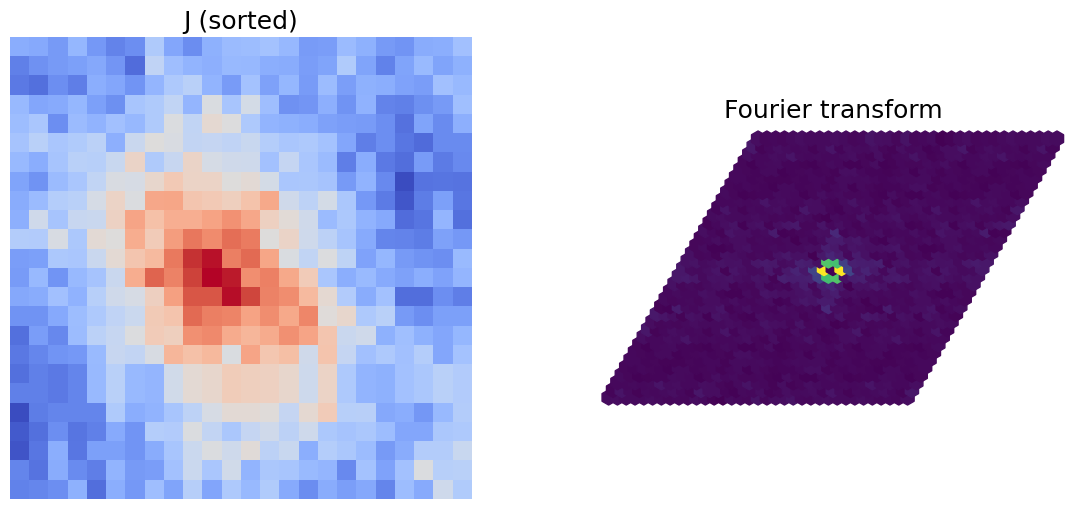

In [94]:
n = int(np.sqrt(Ng))
# Sort the weights using the ordered index found previously
Jsort = J[total_order][:, total_order]
J_square = np.reshape(Jsort, (n,n,n,n))

# Not sure what is going on here, it is part of the original code
Jmean = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        Jmean += np.roll(np.roll(J_square[i,j], -i, axis=0), -j, axis=1)
        
Jmean[0,0] = np.max(Jmean[1:,1:])
Jmean = np.roll(np.roll(Jmean, n//2, axis=0), n//2, axis=1)
# plt.imshow(Jmean, cmap='coolwarm', interpolation='gaussian')

A = np.asarray([[2,1],[0, np.sqrt(3)]])/2
Ainv = np.linalg.inv(A)
im = scipy.ndimage.affine_transform(Jmean, Ainv, mode='wrap')

imroll = np.roll(np.roll(im, -n//4, axis=0), 0, axis=1)
# imroll = scipy.ndimage.gaussian_filter(imroll, sigma=(1,1))

n = int(np.sqrt(N))
width = 18
xs = np.arange(2*width-1)
X,Y = np.meshgrid(xs,xs)
XY = np.stack((X.ravel(),Y.ravel()),0)
T = np.array([[1,0.5],[0,np.sqrt(3)/2]])
XY = T.dot(XY)#+ np.random.randn(*XY.shape)/100 

idxs = np.arange(-width+1, width)
im_fft = np.abs(np.fft.fft2(im))
im_fft[0,0] = 0

f, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[1].scatter(XY[0],XY[1],s=120,c=im_fft[idxs][:,idxs].ravel(),
            marker='h', cmap='viridis')
ax[1].set_aspect('equal')
ax[1].set_axis_off()
ax[1].set_title("Fourier transform")

ax[0].imshow(imroll, cmap='coolwarm')
ax[0].set_title('J (sorted)')
ax[0].set_axis_off()

## Linearized RNN Dynamics

# Figure 6G of Sorscher paper

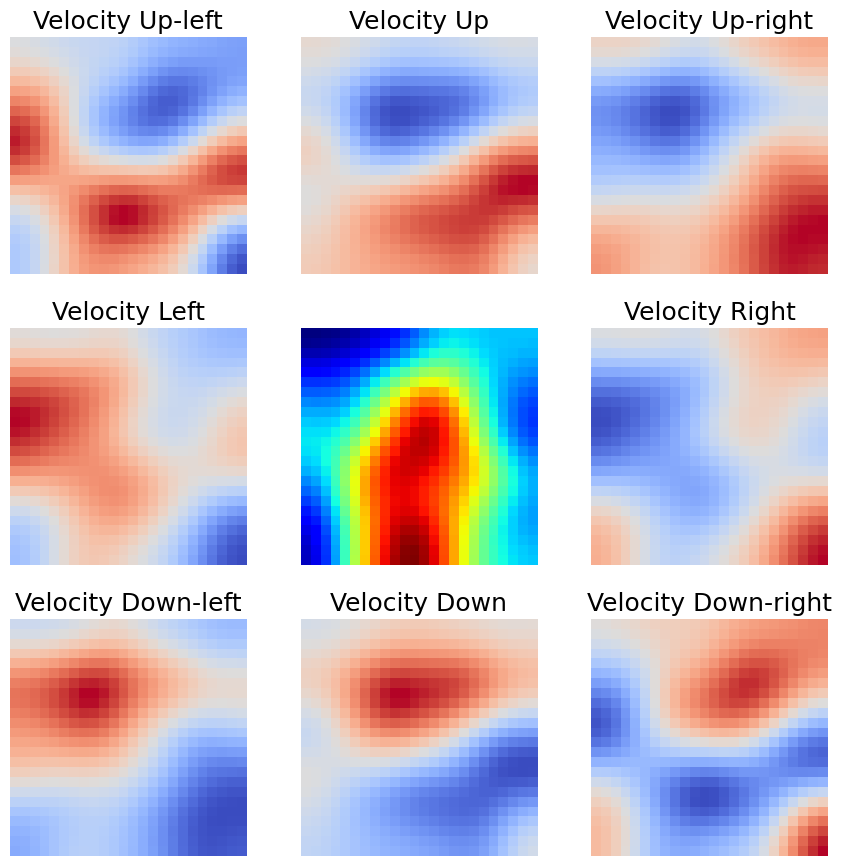

In [97]:
# Recurrent weights and input weights for velocity
J = real_rnn.recurrent_W.T.detach().cpu().numpy()
M = real_rnn.velocity_W.T.detach().cpu().numpy()

thetas = np.linspace(0, 2 * np.pi, 8, endpoint=False)
clock_idxs = np.roll([0, 1, 2, 5, 8, 7, 6, 3], 1)
idx = np.ravel_multi_index((25, 25), (res, res))
# Derivative of non-linear function, see equation 46
# and section Velocity-based updating of positional information in two dimensions in the main paper
G = (J @ rate_map) > 0

# Head directions in radians
head_directions = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
# Just a list with axis indexes to plot the rates in neural sheet space
subplot_coordinates = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
dir_titles = ["Right", "Up-right", "Up", "Up-left", "Left", "Down-left", "Down", "Down-right"]

f, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(8):
    theta = head_directions[i]
    axi, axj = subplot_coordinates[i]

    # See equations 45 to 47
    v = np.stack([np.cos(theta), np.sin(theta)])
    Mv = M.T @ v
    GMv = G[:, idx] * Mv
    JGMv = J @ GMv

    im = JGMv[total_order].reshape(n, n)
    im = scipy.ndimage.gaussian_filter(im, (3, 3))
    ax[axi, axj].imshow(im, cmap='coolwarm')
    ax[axi, axj].set_axis_off()
    ax[axi, axj].set_title(f"Velocity {dir_titles[i]}")

center_ratemap = rate_map[total_order, idx].reshape(n, n)
# It is intersting to see what you get when you remove the blurring
center_ratemap = scipy.ndimage.gaussian_filter(center_ratemap, (3, 3))
ax[1, 1].imshow(center_ratemap, cmap='jet')
ax[1, 1].set_axis_off()
plt.tight_layout()


# Figude 6I

(24, 24)

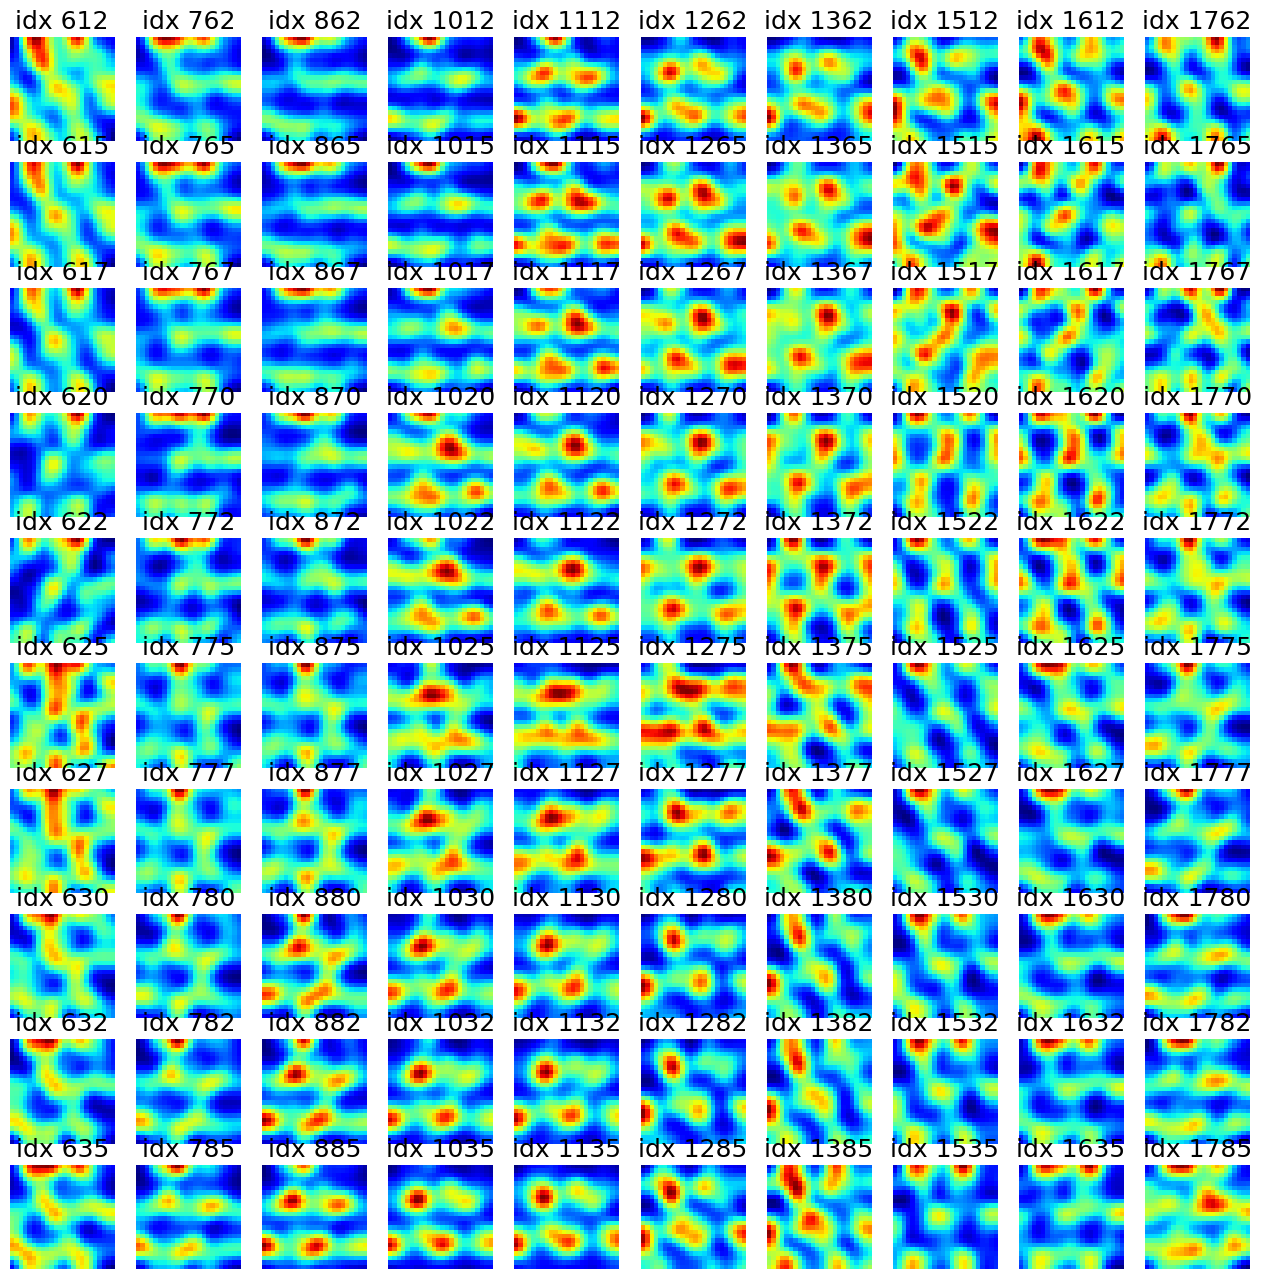

In [98]:
# Skew matrix to transform parallelogram unit cells to squares
A = np.asarray([[2,1],[0, np.sqrt(3)]])/4
Ainv = np.linalg.inv(A)

freq = 2
nplots=10
fig, axes = plt.subplots(nplots,nplots, figsize=(16,16))
for i in range(nplots):
    for j in range(nplots):
        # Not sure what is happening here, it is part of the original code
        # It seems like it is projecting the rates to some space where you can see the grids
        # We use this later to plot the rates in neural sheet space for each velocity
        idx = np.ravel_multi_index(((i+nplots//2)*res//nplots//freq,
                                    (j+nplots//2)*res//nplots//freq), (res,res))
        im = rm_sort_square[:,:,idx]
        im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
        im = scipy.ndimage.gaussian_filter(im, sigma=(2,2))
        axes[j,i].imshow(im.T, cmap='jet')
        axes[j, i].set_title(f"idx {idx}")
        axes[j,i].axis('off')
im.shape

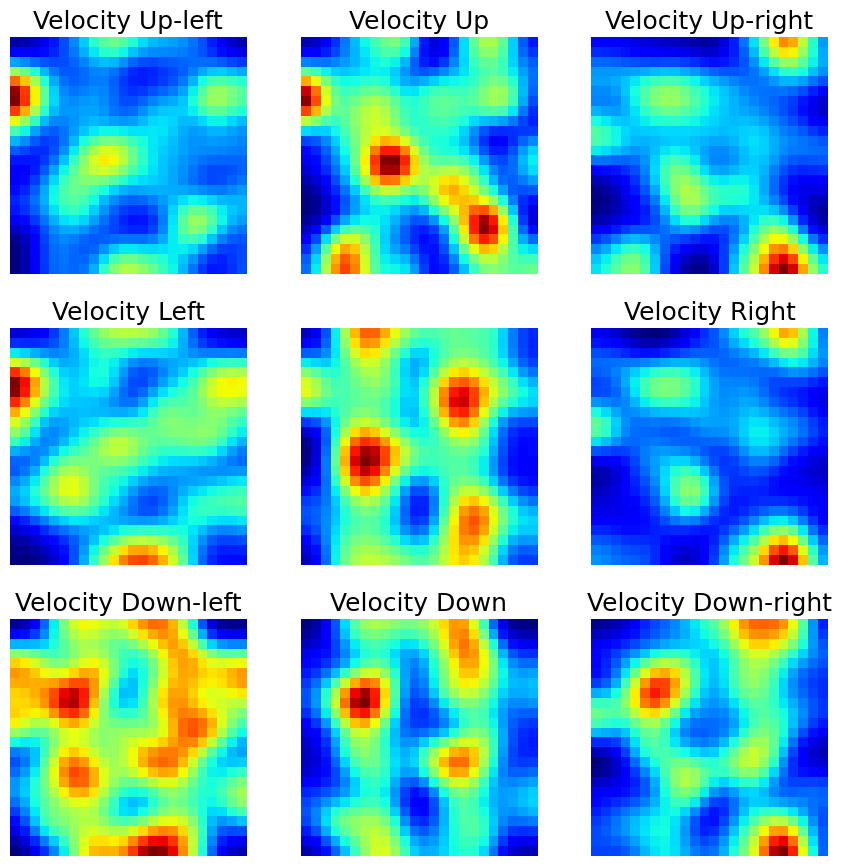

In [99]:
thetas = np.linspace(0, 2 * np.pi, 8, endpoint=False)
clock_idxs = np.roll([0, 1, 2, 5, 8, 7, 6, 3], 1)
idx = 1272  # Pick a nice grid from above and use its index
A = np.asarray([[2,1],[0, np.sqrt(3)]])/4
Ainv = np.linalg.inv(A)

# Head directions in radians
head_directions = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
# Just a list with axis indexes to plot the rates in neural sheet space
subplot_coordinates = [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]
dir_titles = ["Right", "Up-right", "Up", "Up-left", "Left", "Down-left", "Down", "Down-right"]
smoothing = 2

f, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(8):
    theta = head_directions[i]
    axi, axj = subplot_coordinates[i]

    # See equations 2 in the appendix
    v = np.stack([np.cos(theta), np.sin(theta)]) * 0.5
    Mv = M.T @ v
    rate = np.maximum((J @ rate_map)[:, idx] + Mv, 0)
    rate = rate[total_order]

    im = rate.reshape(n, n)
    im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
    # THE SMOOTHING IS QUITE IMPORTAN, otherwise you'll se a bunch of dots
    im = scipy.ndimage.gaussian_filter(im, (smoothing, smoothing))
    ax[axi, axj].imshow(im, cmap='jet')
    ax[axi, axj].set_axis_off()
    ax[axi, axj].set_title(f"Velocity {dir_titles[i]}")

center_ratemap = rate_map[total_order, idx].reshape(n, n)
# It is interesting to see what you get when you remove the blurring
center_ratemap = scipy.ndimage.affine_transform(center_ratemap, Ainv, mode='wrap')
center_ratemap = scipy.ndimage.gaussian_filter(center_ratemap, (smoothing, smoothing))
ax[1, 1].imshow(center_ratemap, cmap='jet')
ax[1, 1].set_axis_off()
plt.tight_layout()

# Train your own path integrator
You can delete any of the functions in the class and the code should work just fine. 
You can use the exact same code as above to make plots and examine your custom network.

In [100]:
class MyPathIntegrator(Sorscher2022exercise):
    
    def __init__(self, Ng, Np, sequence_length, weight_decay, place_cells, activation=torch.nn.ReLU, learning_rate=5e-3,
            device="cuda", learning_rule="adam"):
        super().__init__(Ng, Np, sequence_length, weight_decay, place_cells, activation, learning_rate, device, learning_rule)
        
    def g(self, input):
        """
        Args:
            inputs: tuple with velocity and initial place cell activity with shapes [seq_len, batch, 2] and [batch, Np].

        Returns:
            g: Batch of grid cell activations with shape [sequence_length, batch, Ng].
        """
        velocity, init_place_cell = inputs
        # We take some weights and transform the activity of the place cells
        # to the space of grid cells by suing the enoder weights
        initial_states = init_place_cell @ self.encoder_W.T
        # g, _ = self.RNN(velocity, initial_states)

        batch_size = velocity.shape[1]
        h_t_minus_1 = initial_states
        h_t = initial_states
        g_cell_activity = []
        for t in range(self.sequence_length):
            # See equation 2 in the appendix
            linear_input = velocity[t] @ self.velocity_W.T + h_t_minus_1 @ self.recurrent_W.T
            h_t = self.non_linearity(linear_input)
            g_cell_activity.append(h_t)
            h_t_minus_1 = h_t
        g_cell_activity = torch.stack(g_cell_activity)
        return g_cell_activity

    def predict(self, inputs):
        # Inputs are the same as for the method self.g()
        # Get grid cell rates
        g_cell_activity = self.g(inputs)
        # Decode position form grid cell rates to place cell rates
        # We need to softmax later
        pred_place_cells = g_cell_activity @ self.decoder_W
        return pred_place_cells
    
    def compute_loss(self, inputs, pc_outputs, pos):
        """
        Args:
            inputs: tuple with velocity and initial place cell activity with shapes [seq_len, batch, 2] and [batch, Np].
            pc_outputs: Place cell activity for the whole trajectory, these are the target of the bptt step (seq_len, batch, n_place_cells)
            pos: True position of the agent with shape [seq_len, batch, 2]
        Returns:
            loss: Loss value
            err: Decoding error
        """
        y = pc_outputs
        preds = self.predict(inputs)
        yhat = self.softmax(self.predict(inputs))
        loss = -(y * torch.log(yhat)).sum(-1).mean()

        # Weight regularization
        loss += self.weight_decay * (self.recurrent_W**2).sum()

        # Compute decoding error
        pred_pos = self.place_cells.get_nearest_cell_pos(preds)
        err = torch.sqrt(((pos - pred_pos) ** 2).sum(-1)).mean()
        return loss, err
    
    def bptt_update(self, inputs, place_cells_activity, position):
        """
        Perform backpropagation through time and update weights.
        """
        self.optimizer.zero_grad()
        loss, err = self.compute_loss(inputs, place_cells_activity, position)
        loss.backward()
        self.optimizer.step()

        return loss.detach().cpu().numpy(), err.detach().cpu().numpy()
    
    def train_RNN(self, data_generator, training_steps):
        """
        Perform backpropagation through time and update weights.
        """
        loss_hist = []
        pos_err_hist = []

        for i in tqdm(range(training_steps)):
            # Inputs below is a tuple with velocity vector and initial place cell activity
            # pc outputs is the place cell activity for the whole trajectory, these are the target of the bptt step
            inputs, pc_outputs, positions = next(data_generator)
            loss, pos_err = self.bptt_update(inputs=inputs, place_cells_activity=pc_outputs, position=positions)
            loss_hist.append(loss)
            pos_err_hist.append(pos_err)

        # Save training results for later
        self.loss_hist = np.array(loss_hist)
        self.pos_err_hist = np.array(pos_err_hist)

        return self.loss_hist, self.pos_err_hist
    
    def _initialize_weights(self):
        # Input weights
        # Ideally we would use uniform initialization, between -np.sqrt(in_features), +np.sqrt(in_features)
        k_g = 1/self.Ng
        k_p = 1/self.Np
        np_encoder_W = np.random.uniform(-np.sqrt(k_g), np.sqrt(k_g), size=(self.Ng, self.Np))
        recurrent_W = np.random.uniform(-np.sqrt(k_g), np.sqrt(k_g), size=(self.Ng, self.Ng))
        np_velocity_W = np.random.uniform(-np.sqrt(k_g), np.sqrt(k_g), size=(self.Ng, 2))
        np_decoder_W = np.random.uniform(-np.sqrt(k_p), np.sqrt(k_p), size=(self.Ng, self.Np))

        self.encoder_W = torch.tensor(np_encoder_W, requires_grad=True, dtype=self.dtype, device=self.device)
        self.recurrent_W = torch.tensor(recurrent_W, requires_grad=True, dtype=self.dtype, device=self.device)
        self.velocity_W = torch.tensor(np_velocity_W, requires_grad=True, dtype=self.dtype, device=self.device)
        self.decoder_W = torch.tensor(np_decoder_W, requires_grad=True, dtype=self.dtype, device=self.device)

        self.softmax = torch.nn.Softmax(dim=-1)